# Analysing Review Composition (Human Annotations)


This notebook produces the following figures and tables for the JCLS paper:

- Figure 1 (presence of categories)
- Table 2 and 4 (frequency of categories)
- Figure 4 and 7 (correlation of categories)
- Figures 5 and 6 (presence of categories)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns


from mapping import map_cat_string, cat_tuples

anno_file = '../data/review_classification_annotations.tsv.gz'
annos = pd.read_csv(anno_file, sep='\t', compression='gzip')

In [2]:
import re

review_num_sents = annos[['review_id', 'sent_num']].drop_duplicates().review_id.value_counts()

annos['sent_words'] = annos.sent_text.apply(lambda x: len([w for w in re.split(r"\W+", x) if w != '']))

review_num_words = (annos[['review_id', 'sent_num', 'sent_words']]
                    .drop_duplicates()
                    .groupby('review_id')
                    .sent_words.sum())

annos['review_words'] = annos.review_id.apply(lambda x: review_num_words[x])
annos['review_sents'] = annos.review_id.apply(lambda x: review_num_sents[x])

# binning factor
factor = 4
# binning reviews on logarithm of number of words and sentences
annos['bin_words'] = annos.review_words.apply(lambda x: np.power(10, int(factor * np.log(x)/np.log(10)) / factor))
annos['bin_sents'] = annos.review_sents.apply(lambda x: np.power(10, int(factor * np.log(x)/np.log(10)) / factor))
annos.bin_words.value_counts()


bin_words
316.227766     9972
177.827941     7722
100.000000     6312
562.341325     4011
56.234133      2997
31.622777      2205
17.782794      1101
10.000000       339
1000.000000     234
5.623413          9
Name: count, dtype: int64

## Aggregating annotations per sentence and class

In [3]:
maincat_fields = [col for col in annos.columns if col.startswith('CAT__') and '--' not in col]
subcat_fields = [col for col in annos.columns if col.startswith('CAT__') and '--' in col]
allcat_fields = maincat_fields + subcat_fields
meta_fields = [col for col in annos.columns if col not in allcat_fields]

In [4]:
meta_fields

['review_id',
 'sent_id',
 'sent_offset',
 'sent_end',
 'sent_text',
 'annotator',
 'sent_num',
 'num_cats',
 'sent_words',
 'review_words',
 'review_sents',
 'bin_words',
 'bin_sents']

In [5]:
selected_meta = ['review_id', 'sent_num', 'review_sents', 'sent_id', 'sent_offset', 'sent_end', 'sent_text', 'bin_sents', 'bin_words']
cat_score_wide = annos.groupby(selected_meta)[allcat_fields].mean()

In [6]:
cat_score_long = cat_score_wide.reset_index().melt(value_name='score', var_name='cat', id_vars=selected_meta)

cat_score_long['cat_clean'] = cat_score_long.cat.apply(lambda cat: cat.replace('CAT__', '').replace('_', ' '))
cat_score_long['cat_type'] = cat_score_long.cat.apply(lambda x: 'main' if x in maincat_fields else 'sub')
cat_score_long['score_binary'] = cat_score_long.score.apply(lambda x: 0 if x < 0.66 else 1)

## Plotting Fraction of Reviews with Categories

In [7]:
import matplotlib.pyplot as plt


main_cat_order = [
    'Reader response', 
    'Content', 
    'Style',
    'Author', 
    'Other works',
    'Classification', 
    'Recommendations', 
]

In [8]:
cat_sent_binary = (cat_score_long[cat_score_long.cat_type == 'main']
                   .groupby('cat_clean')
                   .score_binary
                   .value_counts()
                   .unstack())

cat_sent_binary['total'] = cat_sent_binary.sum(axis=1)
cat_sent_binary = cat_sent_binary[[0, 1]].T.div(cat_sent_binary.total).T.rename(columns={1: 'sentence'}).reset_index().rename(columns={'cat_clean': 'Category'}).set_index('Category')


cat_review_binary = (cat_score_long[cat_score_long.cat_type == 'main']
                     .groupby(['review_id', 'cat_type', 'cat_clean'])
                     .score_binary
                     .max()
                     .reset_index()
                     .groupby('cat_clean')
                     .score_binary
                     .value_counts()
                     .unstack())

cat_review_binary['total'] = cat_review_binary.sum(axis=1)
cat_review_binary = cat_review_binary[[0, 1]].T.div(cat_review_binary.total).T.rename(columns={1: 'review'}).reset_index().rename(columns={'cat_clean': 'Category'}).set_index('Category')


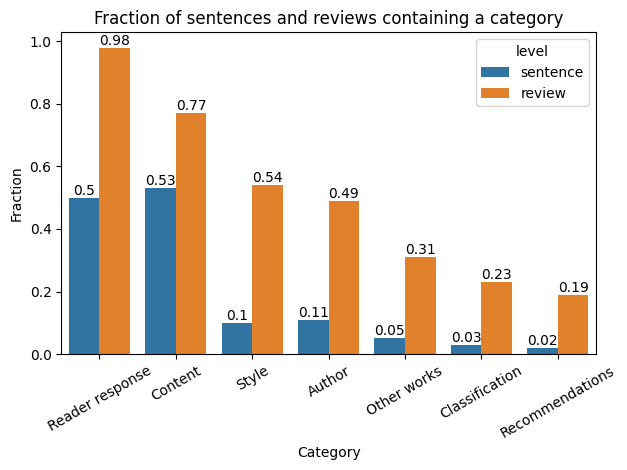

In [9]:
temp = pd.concat([
    cat_sent_binary.sentence,
    cat_review_binary.review
], axis=1).reset_index().melt(id_vars=['Category'], var_name='level', value_name='Fraction').set_index('Category')
temp['Fraction'] = temp.Fraction.apply(lambda x: np.round(x, 2))

ax = sns.barplot(temp.loc[main_cat_order], x='Category', y='Fraction', hue='level')
ax.bar_label(ax.containers[0], fontsize=10);
ax.bar_label(ax.containers[1], fontsize=10);
ax.set_title('Fraction of sentences and reviews containing a category')

plt.xticks(rotation=30)
plt.tight_layout()

ax.figure.savefig('../images/review_classification/category_occurrence-sentence_review-main_categories-barplot.jpg')

This corresponds to Figure 1 in the paper.

## Writing majority vote annotations to file

In [185]:
cat_score_wide.to_csv('../data/review_sentence_classification-majority_vote.tsv', sep='\t', index=False)
cat_score_wide.to_csv('../../../../impact-of-fiction/data/annotations/review_sentence_classification-majority_vote.tsv', sep='\t', index=False)


## Mapping category names for display

Based on the available space in tables and plots, we adjust the category labels.

In [13]:
cat_score_long['cat'] = cat_score_long.cat.apply(lambda x: x.replace('CAT__', ''))
cat_score_wide = cat_score_long.pivot(index=['review_id', 'sent_num', 'sent_offset', 'sent_end', 'sent_text'], columns='cat', values='score_binary').reset_index()


In [14]:
cat_score_wide['sent_length'] = cat_score_wide.apply(lambda row: row['sent_end'] - row['sent_offset'], axis=1)

In [24]:
from itertools import combinations

main_cats = [
    'Author', 'Classification', 'Content', 
    #'None',
    'Other_works', 'Reader_response',
    'Recommendations', 'Style',
]

main_cats_clean = [cat.replace('_', ' ') for cat in main_cats]

main_cats_short = [
    'Auth', 'Class.', 'Cont.', 
    #'None',
    'Other', 'Resp.',
    'Rec.', 'Style',
]

sub_cats = [
    'Content--Narrative', 'Content--Other', 'Content--Quote', 'Content--Theme', 
    'Reader_response--Evaluation_of_quality', 'Reader_response--Feelings',
    'Reader_response--Identification_and_immersion',
    'Reader_response--Reading_Context', 'Reader_response--Reception',
    'Reader_response--Reflection', 
    'Style--Context', 'Style--Structure', 'Style--Stylistic_features'
]

specific_cats = ['Author', 'Classification', 'Other_works', 'Recommendations'] + sub_cats



## Occurrence of Categories

In [17]:
cat_freq = pd.concat([cat_score_wide[main_cats].sum(), cat_score_wide[sub_cats].sum()]).sort_index()
cat_freq.index = pd.Index([re.sub(r".*--", "~~~~", cat) for cat in cat_freq.index], name='Category')

cat_freq = cat_freq.rename('Freq.').to_frame()#.reset_index()#.set_index('Category')

table = cat_freq.style.format(thousands=',').to_latex()
# table = cat_freq.style.format(thousands=',').to_latex(index=False,
                          
#                   float_format="{:.2f}".format,
# )
print(table)


\begin{tabular}{lr}
 & Freq. \\
Category &  \\
Author & 1,328 \\
Classification & 343 \\
Content & 6,197 \\
~~~~Narrative & 5,339 \\
~~~~Other & 259 \\
~~~~Quote & 338 \\
~~~~Theme & 172 \\
Other_works & 612 \\
Reader_response & 5,798 \\
~~~~Evaluation_of_quality & 3,182 \\
~~~~Feelings & 778 \\
~~~~Identification_and_immersion & 320 \\
~~~~Reading_Context & 603 \\
~~~~Reception & 83 \\
~~~~Reflection & 997 \\
Recommendations & 243 \\
Style & 1,110 \\
~~~~Context & 11 \\
~~~~Structure & 58 \\
~~~~Stylistic_features & 962 \\
\end{tabular}



This corresponds to the right-most column of Table 2 in the paper.

In [18]:
s_freq = cat_score_wide[main_cats].sum(axis=1).value_counts().sort_index()
s_frac = s_freq / s_freq.sum()
num_cats = pd.concat([s_freq, s_frac.rename('fraction')], axis=1).reset_index().rename(columns={'index': '# categories'})
num_cats
print(num_cats.to_latex(index=False, float_format="{:.2f}".format))

\begin{tabular}{rrr}
\toprule
# categories & count & fraction \\
\midrule
0 & 526 & 0.05 \\
1 & 7419 & 0.64 \\
2 & 2941 & 0.25 \\
3 & 664 & 0.06 \\
4 & 82 & 0.01 \\
5 & 2 & 0.00 \\
\bottomrule
\end{tabular}



This table corresponds to Table 4 in the paper.

## Correlation of categories



In [19]:
def map_row_corr_to_interval(row):
    return [map_corr_to_interval(corr) for corr in row]
    
def map_corr_to_interval(corr):
    corr = abs(corr)
    levels = [0.2, 0.4, 0.6, 0.8, 1.0]
    for li, level in enumerate(levels):
        if level >= corr:
            return li
    return None
    


In [20]:
import dataframe_image as dfi
import sys

#!{sys.executable} -m pip install dataframe_image --upgrade

dfi.__version__

'0.2.7'

In [21]:

corr_df = cat_score_wide[main_cats].corr(method='pearson')
corr_df.index = main_cats_clean
corr_df.index = main_cats_clean
corr_columns = [('Pearson correlation', col) for col in main_cats_short]
corr_df.columns = pd.MultiIndex.from_tuples(corr_columns, )


In [22]:
corr_df = cat_score_wide[main_cats].corr(method='pearson')
corr_df.index = main_cats_clean
corr_df.index = main_cats_clean
corr_columns = [('Pearson correlation', col) for col in main_cats_short]
corr_df.columns = pd.MultiIndex.from_tuples(corr_columns, )
gmap = corr_df.apply(map_row_corr_to_interval)

In [23]:

table = (corr_df
         .style
         .format(precision=3)
         #.hide(axis='index')
         .background_gradient(axis=None, gmap=gmap))
await dfi.export_async(table, '../images/overlap/correlation_pearson-main_cats.png', dpi=150)
table

This figure corresponds to Figure 4 in the paper. 

In [204]:
meta_cols = ['review_id', 'sent_num', 'sent_offset', 'sent_end', 'sent_text', 'sent_length', 'total_specific']
cat_cols = [col for col in cat_score_wide.columns if col not in meta_cols and col != 'None']
super_cats = ['Content', 'Reader_response', 'Style']
specific_cats = [cat for cat in cat_cols if cat not in super_cats]

specific_cat_map = {
    'Author': 'Auth',
    'Classification': 'Class',
    'Content--Narrative': 'Content\nNarrative.',
    'Content--Other': 'Content\nOther',
    'Content--Quote': 'Content\nQuote',
    'Content--Theme': 'Content\nTheme',
    'Other_works': 'Other',
    'Reader_response--Evaluation_of_quality': 'Resp.\nEval.',
    'Reader_response--Feelings': 'Resp.\nFeel.',
    'Reader_response--Identification_and_immersion': 'Resp.\nIdent.',
    'Reader_response--Reading_Context': 'Resp.\nCont.',
    'Reader_response--Reception': 'Resp.\nRecep.',
    'Reader_response--Reflection': 'Resp.\nRefl.',
    'Recommendations': 'Rec.',
    'Style--Context': 'Style\nCont.',
    'Style--Structure': 'Style\nStruc.',
    'Style--Stylistic_features': 'Style\nfeat.'
}

In [205]:
selected_cols = specific_cats

corr_df = cat_score_wide[selected_cols].corr(method='pearson')

corr_columns = [('Pearson correlation', specific_cat_map[col]) for col in selected_cols]
corr_df.columns = pd.MultiIndex.from_tuples(corr_columns, )
gmap = corr_df.apply(map_row_corr_to_interval)

table = (corr_df
         .style
         .format(precision=3)
         #.hide(axis='index')
         .background_gradient(axis=None, gmap=gmap))
await dfi.export_async(table, '../images/overlap/correlation_pearson-specific_cats.png', dpi=150)
table

This figure corresponds to Figure 7 in the paper. 

## Analysing presence of categories and review length

In [265]:
cat_review_binary = (cat_score_long[cat_score_long.cat_type == 'main']
                     .groupby(['review_id', 'bin_words', 'bin_sents', 'cat_type', 'cat_clean'])
                     .score_binary
                     .max()
                     .reset_index()
                     .groupby(['bin_sents', 'cat_clean'])
                     .score_binary
                     .value_counts()
                     .unstack()
                    )

cat_review_binary
cat_review_binary['total'] = cat_review_binary.sum(axis=1)
cat_review_binary = cat_review_binary[[0, 1]].T.div(cat_review_binary.total).T.rename(columns={1: 'review'}).reset_index().rename(columns={'cat_clean': 'Category'})#.set_index('Category')

cat_review_binary

score_binary,bin_sents,Category,0,review
0,1.000000,Author,0.838235,0.161765
1,1.000000,Classification,0.955882,0.044118
2,1.000000,Content,0.720588,0.279412
3,1.000000,None,1.000000,NaN
4,1.000000,Other works,0.764706,0.235294
...,...,...,...,...
59,56.234133,None,1.000000,NaN
60,56.234133,Other works,NaN,1.000000
61,56.234133,Reader response,NaN,1.000000
62,56.234133,Recommendations,1.000000,NaN


## Presence of categories

The plots below are based on the human annotations only. We also have these plots for the annotations for all reviews based on a trained robBERT model (see notebook `notebook-4-review_composition_full_annotations.ipynb`).

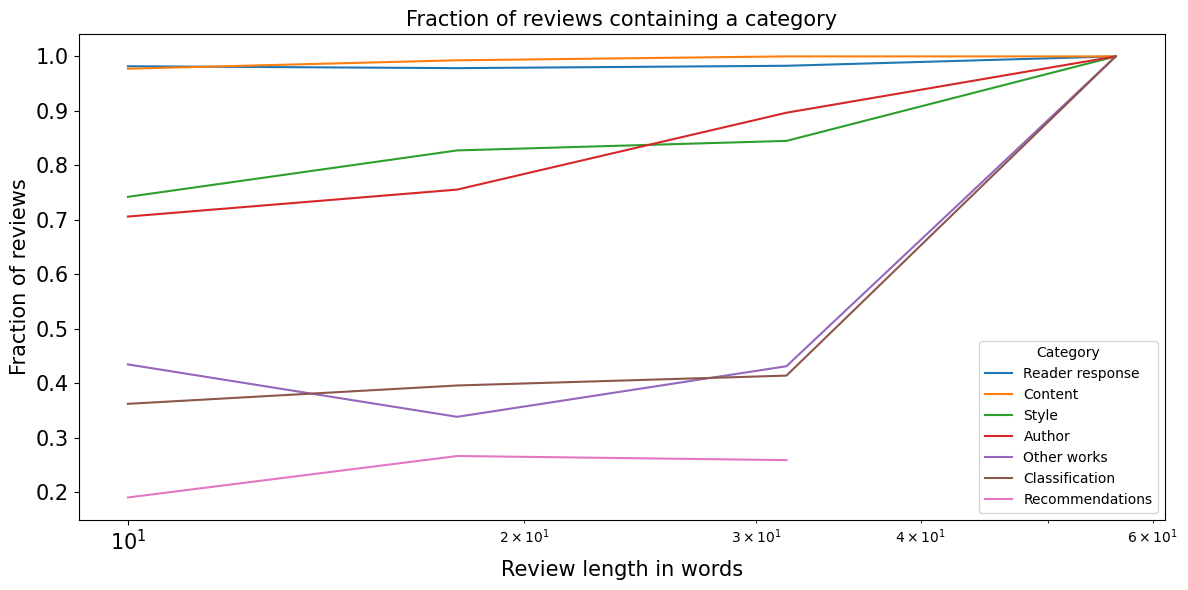

In [268]:
import matplotlib.ticker as mticker

ax = sns.lineplot(cat_review_binary[cat_review_binary.bin_sents.between(5.75, 999)], x='bin_sents', y='review', hue='Category', hue_order=main_cat_order)
ax.set_title('Fraction of reviews containing a category', fontsize=15)

ax.figure.set_size_inches(12,6)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel('Review length in words', fontsize=15)
ax.set_ylabel('Fraction of reviews', fontsize=15)
ax.set_xscale('log')
# ax.set_xticks([10, 50, 100, 250, 500])
# ax.get_xaxis().set_major_formatter(mticker.ScalarFormatter())
plt.tight_layout()

ax.figure.savefig('../images/composition/category-review_fraction.png', dpi=150)

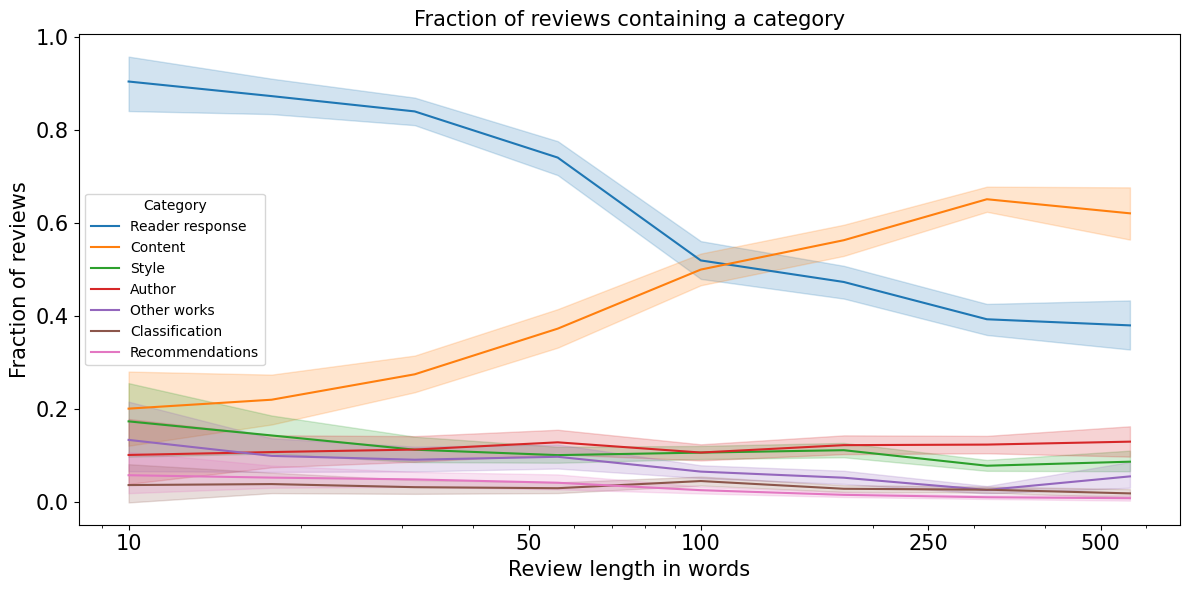

In [261]:
cat_score_long
cat_review_freq = (cat_score_long[cat_score_long.cat_type == 'main']
                     .groupby(['review_id', 'review_sents', 'bin_words', 'cat_type', 'cat_clean'])
                     .score_binary
                     .sum()
                     #.groupby(['bin_words', 'cat_clean'])
                     # .score_binary
                     #.value_counts()
                     .unstack()
                     .reset_index()
                     
                  )

cat_review_freq#[main_cats]
clean_cats = ['Author', 'Content', 'Recommendations', 'Other works',
       'Classification', 'Reader response', 'Style']
meta_cols = [col for col in cat_review_freq.columns if col not in clean_cats]

cat_review_frac = pd.concat([
    cat_review_freq[clean_cats].T.div(cat_review_freq.review_sents).T, 
    cat_review_freq[meta_cols]
], axis=1)

cat_review_frac_long = cat_review_frac.melt(value_vars=clean_cats, id_vars=meta_cols, value_name='frac', var_name='Category')

cat_review_frac_long = cat_review_frac_long[cat_review_frac_long.bin_words.between(10.0, 999)]

ax = sns.lineplot(cat_review_frac_long, x='bin_words', y='frac', hue='Category', hue_order=main_cat_order)
ax.set_title('Fraction of reviews containing a category', fontsize=15)

ax.figure.set_size_inches(12,6)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel('Review length in words', fontsize=15)
ax.set_ylabel('Fraction of reviews', fontsize=15)
ax.set_xscale('log')
ax.set_xticks([10, 50, 100, 250, 500])
ax.get_xaxis().set_major_formatter(mticker.ScalarFormatter())
plt.tight_layout()

ax.figure.savefig('../images/composition/category-review_sent_fraction.png', dpi=150)

These plots correspond to Figures 5 and 6 in the appendix of the paper.